In [1]:
using Pkg
using LinearAlgebra
using Symbolics
using SymbolicUtils
using MultivariatePolynomials
using DynamicPolynomials
using HomotopyContinuation             # para plots
using Distributions
using Random
using Plots  

# Função que arredonda polinômios

function roundp(p)
      if p isa AbstractPolynomialLike
          cs = coefficients(p)
          ms = monomials(p)
          return isempty(cs) ? zero(p) : sum(round(c; digits=1) * m for (c, m) in zip(cs, ms))
      elseif p isa Number
          return round(p; digits=2)
      elseif p isa AbstractArray
          return map(roundp, p)
      else
          error("Unsupported type in roundp: $(typeof(p))")
      end
  end
  # -----


function adj(A::AbstractMatrix)
n, m = size(A)
@assert n == m "adjugate requer matriz quadrada"
C = Matrix{eltype(A)}(undef, n, n)  # matriz de cofatores
idx = collect(1:n)
for i in 1:n, j in 1:n
    r = idx[idx .!= i]
    c = idx[idx .!= j]
    C[i, j] = ((-1)^(i + j)) * det(A[r, c])   # cofactor(i,j)
end
return transpose(C)  # adj(A) = cof(A)'
end  ;

function expand_vector(v) 
    return [ModelKit.expand(v[i]) for i in 1:length(v)] end 

expand_vector (generic function with 1 method)

In [13]:

# Parâmetros:

n = 1000
k = 2

Random.seed!(123)

X = rand(n, k)
beta_0 = [3,2]


y = X* beta_0 + rand(Normal(0,1), n) ; 

In [14]:
@var β[1:k] λ s

g_n = X'*(y - X*β) 

Ω =  sum( ( y[i] - X[i,:]'*β)^2 *  X[i,:]*X[i,:]' for i in 1:n  ) 


p = g_n' * adj(Ω) * g_n
q = det(Ω)


h = β[1]^2 - β[2]^3 


∇h = [ differentiate(h, β[i]) for i in 1:k]
∇p = [ differentiate(p, β[i]) for i in 1:k]
∇q = [ differentiate(q, β[i]) for i in 1:k] ; 



In [16]:
eqA =   expand_vector( q*∇p - p *∇q )  


F = vec( eqA  ) 

vars =  β  


F_sys = System(F; variables=vars)


result = solve(F_sys ; start_system = :total_degree)

S_unr = [ real.(round.(sol; digits=4)) for sol in solutions(result)  ] ; 

Tracking 49 paths...   4%|██                            |  ETA: 0:00:48



Tracking 49 paths... 100%|██████████████████████████████| Time: 0:00:02
                   # paths tracked: 49
   # non-singular solutions (real): 43 (3)
       # singular endpoints (real): 0 (0)
          # total solutions (real): 43 (3)


In [33]:
eqA =  expand_vector(  q*∇p - p *∇q + λ* (q^2)* ∇h  ) 
eqB = h + s^2
eqC = λ * s


F = vec( [eqA ; eqB ; eqC] ) 

vars = [ β ; λ ; s ]


F_sys = System(F; variables=vars)


result = solve(F_sys ; start_system = :total_degree)

complex_sols = solutions(result)

S_res = [ real.(round.(sol; digits=4)) for sol in complex_sols  ]  ; 


Tracking 660 paths...  40%|████████████                 |  ETA: 0:00:01



Tracking 660 paths...  50%|███████████████              |  ETA: 0:00:01



Tracking 660 paths...  60%|██████████████████           |  ETA: 0:00:01



Tracking 660 paths...  73%|██████████████████████       |  ETA: 0:00:00



Tracking 660 paths...  81%|████████████████████████     |  ETA: 0:00:00



Tracking 660 paths...  98%|█████████████████████████████|  ETA: 0:00:00



Tracking 660 paths... 100%|█████████████████████████████| Time: 0:00:01
                   # paths tracked: 660
   # non-singular solutions (real): 64 (0)
       # singular endpoints (real): 43 (5)
          # total solutions (real): 107 (5)


In [39]:
display([ mixed_volume(F_sys) , length(vars), length(F)] )  #o chat diz que isso indica a existência de infinitas soluções

tol = 0.001  # tolerância
display( count(u -> all(abs.(imag.(u)) .< tol), complex_sols) ) # nenhuma solução real

3-element Vector{Int64}:
 0
 4
 4

0

In [38]:
function Q(b)
   
    g = X'*(y - X*b) 

    Omega =  sum( ( y[i] - X[i,:]'*b)^2 *  X[i,:]*X[i,:]' for i in 1:n  ) 

    return  log( g' * inv( Omega) * g ) 
end    


function H(b)
    return  b[1]^2 - b[2]^3
end   ;


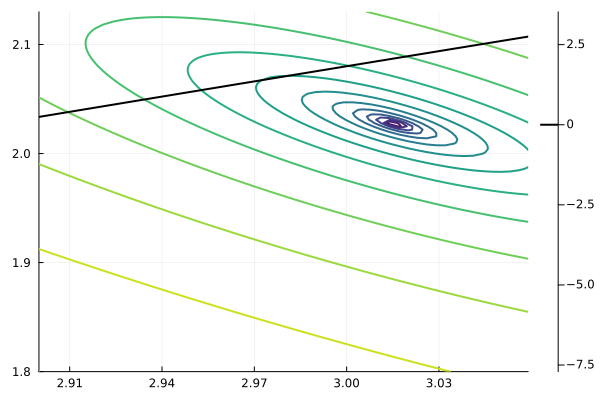

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots D:\Users\b435088\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with different line color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots D:\Users\b435088\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with different levels share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots D:\Users\b435088\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots D:\Users\b435088\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with different line color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots D:\Users\b435088\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple seri

In [20]:
# intervalos

x_grid = [ 3 + i for i in -0.1: 0.003 :0.06 ]
y_grid = [ 2 + i for i in -0.2: 0.003: 0.13 ]


# grade
Z = [Q([xi, yi]) for yi in y_grid, xi in x_grid]
Z2 = [H([xi, yi]) for yi in y_grid, xi in x_grid]

L = range(minimum(Z), maximum(Z), length=15) 

# plota curvas de nível
contour(x_grid, y_grid, Z, levels= L, colormap = :viridis, linewidth=2)

# ponto a destacar
contour!(x_grid, y_grid, Z2, levels=[0], color=:black, linewidth=2, label="x² - y³ = 0")